In [ ]:
#default_exp Experiment

In [ ]:
#hide
#export
from typing import Dict, Any, List
import pandas as pd
import os
from copy import deepcopy

import sys
sys.path.append("..")

from hephaestus.AbstractMethod import *
from hephaestus.IOUtils import *
from hephaestus.DatasetConstruction import *
from hephaestus.HephaestusModel import *
from hephaestus.TrainModels import *

# Experiment

> This is where the science happens. Which model is best? Is it actually beneficial to use EditOperations over raw token sequences when training an NMT model?

In [ ]:
#export
class HephaestusModelEvaluation:
    """
    Helper class to centralize computations when evaluating the effectiveness of a `HephaestusModel`.
    
    Required Arguments:
    
    - `model`: The `HephaestusModel` to evaluate
    - `testSourceMethods`: A list of AbstractMethods representing the buggy abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    - `testTargetMethods`: A list of AbstractMethods representing the fixed abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    
    Optional Arguments:
    
    - `isControl`: Set to `True` if the model represents the control, i.e. the model was trained purely with
      AbstractMethods and not with EditOperations. Defaults to `False`.
  
    Once created, the `HephaestusModelEvaluation` will contain the following attributes which can be freely accessed:
    
    - `outputMethods`: A list of AbstractMethods which were translated from the given buggy (source) AbstractMethods.
      These represent the model's predictions of what it thinks the fixed methods are. Some of these entries may be
      `None`, representing failed predictions.
    - `numPerfectPredictions`: The number of `outputMethods` whose tokens exactly match the actual fixed method according
      to the provided `testTargetMethods`.
    - `perfectPredictionRatio`: The ratio of perfect predictions to total predictions, in the range [0, 1].
    - `numFailedPredictions`: The number of `outputMethods` which were not able to be predicted due to ill-formed
      EditOperations or other factors. These are represented by `None` values in `outputMethods`.
    - `failedPredictionRatio`: The ratio of failed predictions to total predictions, in the range [0, 1].
    - `avgEditDistDecrease`: A value representing how much the model "helped" in reducing the Levenshtein edit distance
      to the `testTargetMethods`. E.g. a value of 3 means that on average, the edit distance from the output methods to
      the target methods was 3 less than the edit distance from the source methods to the target methods. Negative values
      mean that the model made the output methods further away from the target methods than they originally were as given
      by the source methods.
    - `trainingStats`: A Pandas DataFrame representing model information while it was training, as in
      `HephaestusModel.getTrainingStats`.
    """

    def __init__(self, 
        model: HephaestusModel,
        testSourceMethods: List[AbstractMethod],
        testTargetMethods: List[AbstractMethod],
        isControl: bool = False
    ) -> None:

        # use the model to determine output methods
        self.outputMethods = model.translate(testSourceMethods, applyEditOperations = not isControl)

        # sanity check -- make sure that the lengths of all lists of methods are equal
        if not len(testSourceMethods) == len(testTargetMethods) == len(self.outputMethods):
            raise RuntimeError("HephaestusModelEvaluation: method number mismatch")
        
        # determine number of perfect predictions and failed predictions, and edit distance stuff
        self.numPerfectPredictions = 0
        self.numFailedPredictions = 0
        editDistDecreases = []
        for outputMethod, sourceMethod, targetMethod in zip(self.outputMethods, testSourceMethods, testTargetMethods):
            if outputMethod == targetMethod:
                self.numPerfectPredictions += 1
            if outputMethod is None:
                self.numFailedPredictions += 1
            else:
                idealDist = sourceMethod.getEditDistanceTo(targetMethod)
                actualDist = outputMethod.getEditDistanceTo(targetMethod)
                editDistDecreases.append(idealDist - actualDist)
        self.avgEditDistDecrease = sum(editDistDecreases) / len(editDistDecreases)
        
        # obtain perfect prediction and failed prediction ratios
        self.perfectPredictionRatio = self.numPerfectPredictions / len(self.outputMethods)
        self.failedPredictionRatio = self.numFailedPredictions / len(self.outputMethods)
        
        # get the training statistics
        self.trainingStats = model.getTrainingStats()

## Helper functions

In [ ]:
#export
def annotateBarPlot(plot) -> None:
    """
    Annotates the bars of the given `plot` with their values.
    """
    
    maxSize = max([abs(p.get_height()) for p in plot.patches])
    
    for p in plot.patches:
        plot.annotate(
            "{:.1f}".format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + maxSize * 0.05 * (1 if p.get_height() >= 0 else -1)),
            ha = "center",
            va = "center",
            size = 10
        )

In [ ]:
#export
def plotBar(
    data: pd.DataFrame,
    title: str,
    xLabel: str,
    yLabel: str,
    annotate: bool = True
) -> pd.DataFrame:
    """
    Plots an annotated bar graph with the given parameters and returns the `data` DataFrame.
    """
    
    minVal = data.values.min()
    maxVal = data.values.max()
    maxSize = max(abs(minVal), abs(maxVal))
    
    # create plot
    plot = data.plot.bar(
        ylim = (0 if minVal >= 0 else minVal - maxSize * 0.15, 0 if maxVal <= 0 else maxVal + maxSize * 0.15),
        title = title,
        xlabel = xLabel,
        ylabel = yLabel,
        rot = 0
    )
    
    # annotate if necessary
    if annotate:
        annotateBarPlot(plot)
    
    return data

In [ ]:
#export
def plotTrainingAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    lineLabels: List[str],
    title: str
) -> None:
    """
    Plots the training accuracies of the given `evaluations` as a line graph per training step. The line labels are the
    given `lineLabels`. The title is the given `title`.
    """
    
    # create dataframe
    data = {}
    for evaluation, label in zip(evaluations, lineLabels):
        data[label] = evaluation.trainingStats["trainAccuracy"].to_list()
    frame = pd.DataFrame(data, index = evaluations[0].trainingStats["step"].to_list())
    
    # create plot
    plot = frame.plot.line(
        title = title,
        xlabel = "Training Step",
        ylabel = "Training Accuracy %",
        grid = True
    )

In [ ]:
#export
def plotPerfectPredictionAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the perfect prediction accuracies of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    return plotBar(
        data = pd.DataFrame({
            "acc%": [100 * e.perfectPredictionRatio for e in evaluations]
        }, index = xLabels),
        title = title,
        xLabel = "Model",
        yLabel = "Perfect Prediction Accuracy %"
    )

In [ ]:
#export
def plotAllPerfectPredictionAccuracies(
    evaluations: Dict[str, HephaestusModelEvaluation],
    xLabels: List[str]
) -> None:
    """
    Plots the perfect predictions accuracies of all given `evaluations` as a nested bar graph. The x-axis labels are the
    given `xLabels`. Returns the dataframe used to create the graph.
    """
    
    data = {}
    for key in evaluations:
        data[key] = [100 * e.perfectPredictionRatio for e in evaluations[key]]
    frame = pd.DataFrame(data, index = xLabels)
    
    return plotBar(
        data = pd.DataFrame(data, index = xLabels),
        title = "Perfect Prediction Accuracies of All Models",
        xLabel = "Model",
        yLabel = "Perfect Prediction Accuracy %",
        annotate = False
    )

In [ ]:
#export
def plotAvgEditDistDecreases(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the average edit distance decreases of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    return plotBar(
        data = pd.DataFrame({
            "decrease": [e.avgEditDistDecrease for e in evaluations]
        }, index = xLabels),
        title = title,
        xLabel = "Model",
        yLabel = "Average Edit Distance Decrease"
    )

In [ ]:
#export
def plotAllAvgEditDistDecreases(
    evaluations: Dict[str, HephaestusModelEvaluation],
    xLabels: List[str]
) -> None:
    """
    Plots the average edit distance decreases of all given `evaluations` as a nested bar graph. The x-axis labels are the
    given `xLabels`. Returns the dataframe used to create the graph.
    """
    
    data = {}
    for key in evaluations:
        data[key] = [e.avgEditDistDecrease for e in evaluations[key]]
    frame = pd.DataFrame(data, index = xLabels)
    
    return plotBar(
        data = pd.DataFrame(data, index = xLabels),
        title = "Average Edit Distance Decreases of All Models",
        xLabel = "Model",
        yLabel = "Average Edit Distance Decrease",
        annotate = False
    )

In [ ]:
#export
def plotFailedPredictionRates(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the failed prediction rates of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    return plotBar(
        data = pd.DataFrame({
            "rate%": [100 * e.failedPredictionRatio for e in evaluations]
        }, index = xLabels),
        title = title,
        xLabel = "Model",
        yLabel = "Failed Prediction Rate %"
    )

## Preparation

Collect buggy and fixed methods from the testing dataset. These AbstractMethods do not appear at all in the training or validation data.

In [ ]:
testBuggyMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_BUGGY)
testFixedMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_FIXED)

## Default Parameters

Get the `HephaestusModelEvaluation` for each model which was trained with the deafault parameters.

In [ ]:
#collapse_output
defaultControlEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_CONTROL),
    testBuggyMethods,
    testFixedMethods,
    isControl = True
)

[2021-05-16 23:56:12,602 INFO] Translating shard 0.
[2021-05-16 23:56:51,650 INFO] PRED AVG SCORE: -0.0585, PRED PPL: 1.0603


In [ ]:
#collapse_output
defaultBasicEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-16 23:56:59,451 INFO] Translating shard 0.
[2021-05-16 23:58:13,628 INFO] PRED AVG SCORE: -0.0683, PRED PPL: 1.0707


In [ ]:
#collapse_output
defaultStrictEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-16 23:58:22,377 INFO] Translating shard 0.
[2021-05-16 23:58:43,836 INFO] PRED AVG SCORE: -0.4507, PRED PPL: 1.5694


In [ ]:
#collapse_output
defaultLooseEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-16 23:58:51,889 INFO] Translating shard 0.
[2021-05-16 23:59:10,698 INFO] PRED AVG SCORE: -0.4528, PRED PPL: 1.5728


### Training Accuracies

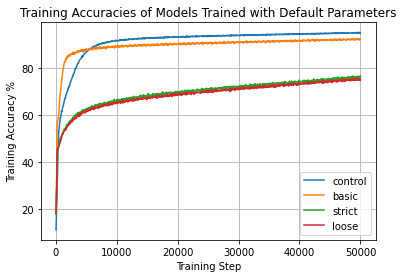

In [ ]:
plotTrainingAccuracies(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    lineLabels =  ["control",          "basic",          "strict",          "loose"],
    title = "Training Accuracies of Models Trained with Default Parameters"
)

### Perfect prediction accuracies

,acc%
control,14.721508
basic,7.986290
strict,7.146530
loose,7.180805


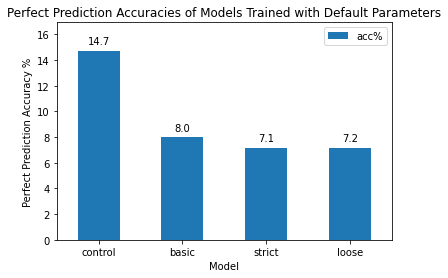

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    xLabels =     ["control",          "basic",          "strict",          "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Default Parameters"
)

### Average Edit Distance Decreases

The *edit distance decrease* is a value representing how much the the `HephaestusModel` "helped" in reducing the Levenshtein edit distance to the fixed methods. E.g. a value of 3 means that on average, the edit distance from the model's outputted methods to the actual fixed methods was 3 less than the edit distance from the original buggy methods to the actual fixed methods. Negative values mean that the model made the output methods further away from the fixed methods than they originally were as given by the buggy methods. Therefore, a higher value is better.

,decrease
control,-1.528192
basic,-2.402546
strict,-1.654924
loose,-1.843648


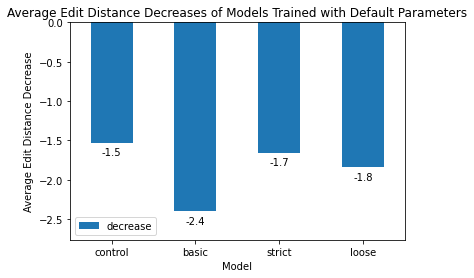

In [ ]:
plotAvgEditDistDecreases(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    xLabels =     ["control",          "basic",          "strict",          "loose"],
    title = "Average Edit Distance Decreases of Models Trained with Default Parameters"
)

### Failed prediction rates

How often did the models fail to output an `AbstractMethod`?

,rate%
control,0.000000
basic,0.377035
strict,0.274207
loose,0.582691


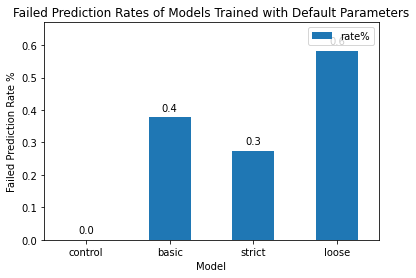

In [ ]:
plotFailedPredictionRates(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    xLabels =     ["control",          "basic",          "strict",          "loose"],
    title = "Failed Prediction Rates of Models Trained with Default Parameters"
)

## Parameter group 1

In [ ]:
#collapse_output
group1ControlEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_CONTROL),
    testBuggyMethods,
    testFixedMethods,
    isControl = True
)

[2021-05-16 23:59:19,660 INFO] Translating shard 0.
[2021-05-16 23:59:58,010 INFO] PRED AVG SCORE: -0.0522, PRED PPL: 1.0535


In [ ]:
#collapse_output
group1BasicEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:00:06,502 INFO] Translating shard 0.
[2021-05-17 00:01:20,760 INFO] PRED AVG SCORE: -0.0668, PRED PPL: 1.0691


In [ ]:
#collapse_output
group1StrictEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:01:29,530 INFO] Translating shard 0.
[2021-05-17 00:01:51,968 INFO] PRED AVG SCORE: -0.4827, PRED PPL: 1.6204


In [ ]:
#collapse_output
group1LooseEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:02:00,110 INFO] Translating shard 0.
[2021-05-17 00:02:17,748 INFO] PRED AVG SCORE: -0.4820, PRED PPL: 1.6193


### Training Accuracies

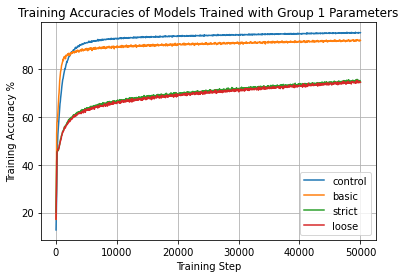

In [ ]:
plotTrainingAccuracies(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    lineLabels =  ["control",         "basic",         "strict",         "loose"],
    title = "Training Accuracies of Models Trained with Group 1 Parameters"
)

### Perfect prediction accuracies

,acc%
control,13.898886
basic,7.626392
strict,8.071979
loose,8.260497


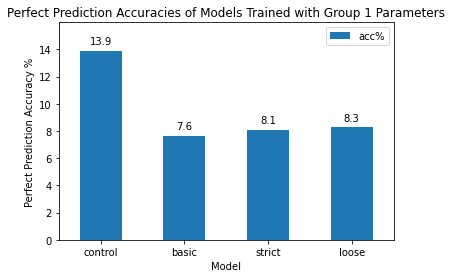

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Group 1 Parameters"
)

### Average Edit Distance Decreases

,decrease
control,-0.891174
basic,-2.691330
strict,-1.456986
loose,-1.596552


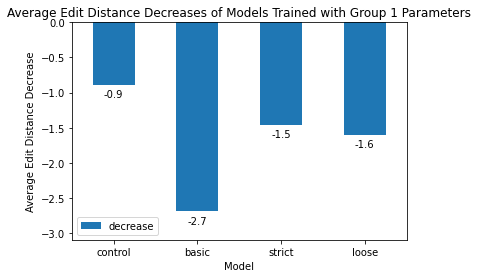

In [ ]:
plotAvgEditDistDecreases(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Average Edit Distance Decreases of Models Trained with Group 1 Parameters"
)

### Failed prediction rates

,rate%
control,0.000000
basic,1.559554
strict,0.394173
loose,0.599829


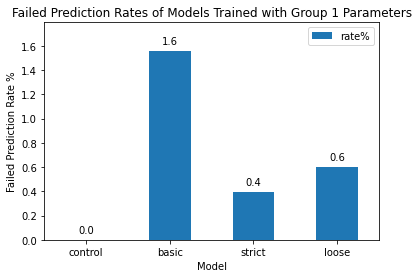

In [ ]:
plotFailedPredictionRates(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Failed Prediction Rates of Models Trained with Group 1 Parameters"
)

## Parameter group 2

The control model for this parameter group is the same as the control model for the default parameter group.

In [ ]:
group2ControlEval = defaultControlEval

In [ ]:
#collapse_output
group2BasicEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP2_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:02:26,390 INFO] Translating shard 0.
[2021-05-17 00:03:39,084 INFO] PRED AVG SCORE: -0.0638, PRED PPL: 1.0659


In [ ]:
#collapse_output
group2StrictEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP2_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:03:47,603 INFO] Translating shard 0.
[2021-05-17 00:04:08,439 INFO] PRED AVG SCORE: -0.4644, PRED PPL: 1.5910


In [ ]:
#collapse_output
group2LooseEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP2_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-05-17 00:04:16,486 INFO] Translating shard 0.
[2021-05-17 00:04:35,999 INFO] PRED AVG SCORE: -0.4754, PRED PPL: 1.6086


### Training Accuracies

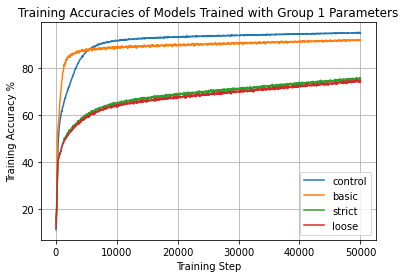

In [ ]:
plotTrainingAccuracies(
    evaluations = [group2ControlEval, group2BasicEval, group2StrictEval, group2LooseEval],
    lineLabels =  ["control",         "basic",         "strict",         "loose"],
    title = "Training Accuracies of Models Trained with Group 1 Parameters"
)

### Perfect prediction accuracies

,acc%
control,14.721508
basic,7.523565
strict,6.820908
loose,7.523565


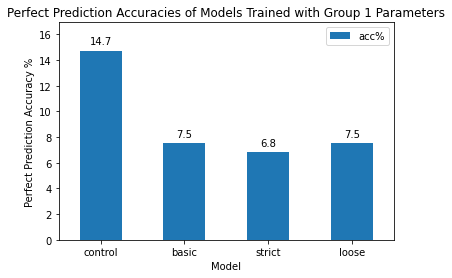

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [group2ControlEval, group2BasicEval, group2StrictEval, group2LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Group 1 Parameters"
)

### Average Edit Distance Decreases

,decrease
control,-1.528192
basic,-2.541187
strict,-1.580217
loose,-1.387632


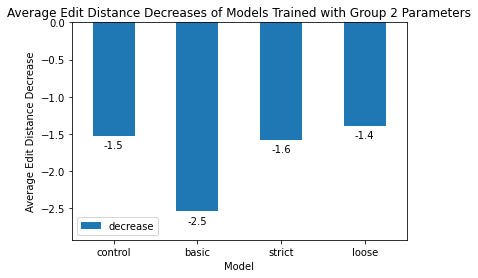

In [ ]:
plotAvgEditDistDecreases(
    evaluations = [group2ControlEval, group2BasicEval, group2StrictEval, group2LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Average Edit Distance Decreases of Models Trained with Group 2 Parameters"
)

### Failed prediction rates

,rate%
control,0.000000
basic,0.342759
strict,0.548415
loose,0.788346


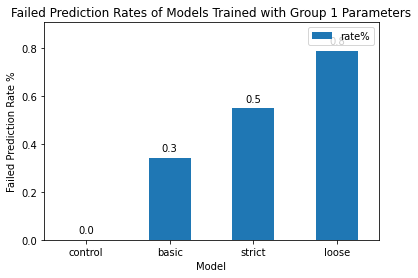

In [ ]:
plotFailedPredictionRates(
    evaluations = [group2ControlEval, group2BasicEval, group2StrictEval, group2LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Failed Prediction Rates of Models Trained with Group 1 Parameters"
)

## Failure cases

If a `HephaestusModel` outputs malformed EditOperations, then those operations cannot be applied to the input method and thus an output method cannot be produced. Therefore, for each model trained with EditOperations, there is a small chance that a method prediction will fail due to malformed EditOperations.

This section aims to look more in depth at the distribution and causes for these failures. We will use the model with the highest failed prediction rate as a benchmark: the model trained on basic condensed EditOperations from parameter group 1, with a failure rate of 1.6%.

### Failure distribution

There are two ways in which a `HephaestusModel` can fail to predict a method:

- The outputted machine string contains a syntax error such that it literally connot be parsed into a valid `CompoundOperation`.
- The syntax is correct, but the indices of the resulting `CompoundOperation` operate on tokens whose indices do not exist in the inputted `AbstractMethod`.

We can determine the failure distribution of the outputted EditOperations by looking at how many failures were caused by syntax errors and how many were caused by index errors.

First, we extract the outputted machine strings from the `raw_output.txt` file and convert them to lists of CompoundOperations. If any machine strings were not able to be converted by the `readCompoundOperationsFromFile` function, then they had syntax errors and will appear as `None` in the returned list.

In [ ]:
compoundOpsLists = readCompoundOperationsFromFile(os.path.join(MODEL_GROUP1_BASIC, "raw_output.txt"))

In [ ]:
numSyntaxFailures = compoundOpsLists.count(None)
numSyntaxFailures

5

Next, we attempt to apply all the well-formed CompoundOperations to the buggy AbstractMethods and count the number of thrown IndexErrors.

In [ ]:
indexFailureMethods = []

for method, compoundOpsList in zip(testBuggyMethods, compoundOpsLists):
    
    methodCopy = deepcopy(method)
    
    if compoundOpsList is not None:
        try:
            methodCopy.applyEditOperations(compoundOpsList)
        except IndexError:
            indexFailureMethods.append(method)

numIndexFailures = len(indexFailureMethods)
numIndexFailures

86

In [ ]:
numTotalFailures = numSyntaxFailures + numIndexFailures
numTotalFailures

91

We see that there were 91 total prediction failures, 5 of which were due to syntax errors and 86 of which were due to index errors. We can verify that this number is the actual amount of methods that were not able to be predicted as given by the `HephaestusModelEvaluation`.

In [ ]:
assert(numTotalFailures == group1BasicEval.outputMethods.count(None))

### Syntax Failures

Now we delve more in depth at the cause of the syntax failures by looking at the malformed machine strings directly.

In [ ]:
syntaxFailureLineIndices = []
for i in range(len(compoundOpsLists)):
    if compoundOpsLists[i] is None:
        syntaxFailureLineIndices.append(i)
        
malformedMachineStrings = []
with open(os.path.join(MODEL_GROUP1_BASIC, "raw_output.txt"), "r") as f:
    lines = f.readlines()
    malformedMachineStrings = [lines[i].strip() for i in syntaxFailureLineIndices]

In [ ]:
for string in malformedMachineStrings:
    print(string + "\n")

<op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> </op> <op> 7 8 <sep> true

<op> 8 9 <sep> </op> <op> 8 9 <sep> </op> <op> 8 9 <sep> return </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 16 <sep>

<op> 8 9 <sep> </op> <op> 8 9 <sep> </op> <op> 8 9 <sep> return </op> <op> 15 16 <sep> </op> <op> 15 16 <sep> </op> <op> 15 

For all of the malformed machine strings, the syntax failures happen because the last represented `CompoundOperation` is cut off. Moreover, all of these strings appear to have a similar number of tokens.

In [ ]:
[len(string.split()) for string in malformedMachineStrings]

[100, 100, 100, 100, 100]

Indeed, all of the malformed machine strings are of length 100. 100 is the default maximum output sequence length for OpenNMT translation, so we can be almost certain that this is the reason why the machine strings appear to be cut off at the end. Since syntax failures only accounted for 5 out of the 91 total failures, it is acceptable to leave this cap in place. Also, it's good to have a maximum output sequence length, as having one prevents outputted sequences from being very long and hogging processing power. 

### Index Failures

Next, we can look at the buggy AbstractMethods which caused the model to output EditOperations which resulted in IndexErrors. Perhaps there is a difference between the lengths of these methods and the lengths of the buggy AbstractMethods overall.

In [ ]:
lengths = [len(method) for method in indexFailureMethods]
avgIndexFailureMethodLength = sum(lengths) / len(lengths)

avgIndexFailureMethodLength

29.558139534883722

In [ ]:
lengths = [len(method) for method in testBuggyMethods]
avgBuggyMethodLength = sum(lengths) / len(lengths)

avgBuggyMethodLength

31.759211653813196

In [ ]:
avgIndexFailureMethodLength - avgBuggyMethodLength

-2.201072118929474

On average, the length of an AbstractMethod which caused an index failure was 2.20 less than the typical inputted AbstractMethod. Therefore, there is evidence that shorter AbstractMethods are more likely to case prediction failures. This is likely due to the fact that a shorter AbstractMethod has a smaller range of valid indices, and as such, the model can more often generate EditOperations which influence out of bounds indices.

It appears that the probability of prediction failure is influenced by the length of the inputted AbstractMethod. Thus, the failure rate can likely be decreased if the data is further subdivided and grouped by length ranges, and models are trained on only one length range. However, this will dramatically reduce the amount of training data each model will have, so ultimately doing this is probably not a good idea.

## Overall Statistics

### Perfect Prediction Accuracies

,default params,group1 params,group2 params
control,14.721508,13.898886,14.721508
basic,7.986290,7.626392,7.523565
strict,7.146530,8.071979,6.820908
loose,7.180805,8.260497,7.523565


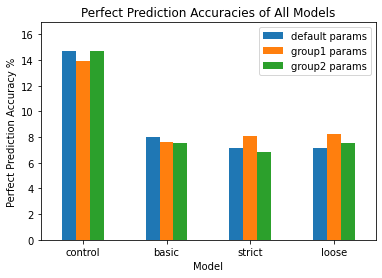

In [ ]:
plotAllPerfectPredictionAccuracies(
    evaluations = {
        "default params": [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
        "group1 params":  [group1ControlEval,  group1BasicEval,  group1StrictEval,  group1LooseEval],
        "group2 params":  [group2ControlEval,  group2BasicEval,  group2StrictEval,  group2LooseEval]
    },
    xLabels =             ["control",          "basic",          "strict",          "loose"]
)

### Average Edit Distance Decreases

,default params,group1 params,group2 params
control,-1.528192,-0.891174,-1.528192
basic,-2.402546,-2.691330,-2.541187
strict,-1.654924,-1.456986,-1.580217
loose,-1.843648,-1.596552,-1.387632


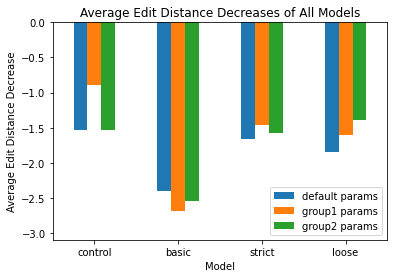

In [ ]:
plotAllAvgEditDistDecreases(
    evaluations = {
        "default params": [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
        "group1 params":  [group1ControlEval,  group1BasicEval,  group1StrictEval,  group1LooseEval],
        "group2 params":  [group2ControlEval,  group2BasicEval,  group2StrictEval,  group2LooseEval]
    },
    xLabels =             ["control",          "basic",          "strict",          "loose"]
)

## Analysis

The most important performace metric is perfect prediction accuracy; it describes how well the model can actually function as a "bug fixer". The control model (trained only with AbstractMethods) performs significantly better than any of the models trained with EditOperations in this regard, no matter the models' training parameters. These results give evidence that training NMT models with EditOperations is not beneficial over the standard approach. There is a negligible difference between the accuracies of models trained with basic, strictly, and loosely condensed EditOperations, which suggests that condensing the EditOperations does not affect the perfect prediction accuracy.

Another model performance metric is edit distance decrease (EDD). The geater this value, the closer the models' predictions approach the true fixed methods (i.e. higher = better). Surprisingly, every single model had a negative average EDD, meaning that all the models predicted methods that were further away from the true fixed methods than the original buggy methods were. The control models had the highest average EDDs overall, although the average EDDs of the strict and loose models are very comparable to those of the control models. Furthermore, the strict and loose models performed much better than the basic models in this regard, suggesting that it is helpful to condense the EditOperations before training. However, since the average EDD for all models was negative, EDD may not be a helpful metric by which to measure model performance.

## Conclusions

It is evidenced that...

- using EditOperations to train NMT models does **not** offer advantages over the standard approach.
- if the NMT models are trained with EditOperations, then it is advantageous to train using strictly or loosely condensed EditOperations over the basic condensed EditOperations.